### MMDetection 설치
* 강의 영상에는 pip install mmcv-full로 mmcv를 설치(약 10분 정도의 시간이 소요)
* 실습코드는 pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html 로 변경(설치에 12초 정도 걸림. 2022.09).
*  2023년 4월 6일 기준으로 mmdetection이 3.0으로 upgrade됨. 실습 코드는 mmdetection 2.x 기준으므로 mmdetection 2.x 소스코드 설치 필요.
* 2024년 9월 colab의 numpy version이 1.24로 upgrade되면서 일부 코드가 동작오류. numpy 1.23 으로 downgrade 적용
* 2025년 1월 17일 Colab의 python 버전이 3.10에서 3.11로 버전업 되면서 pytorch 2.0, torchvision 0.15로 변경. mmcv도 !pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html 로 변경.
* 2025년 8월 25일 Colab의 python 버전이 3.11에서 3.12로 버전업 되면서 더 이상 mmcv-full이 제대로 설치 되지 않음.
* 이에 Colab 환경에서 Kaggle 환경으로 실습환경 이관. Kaggle은 여전히 python 버전이 3.11임.
* 기존 Colab의 디렉토리 구조는 /content 디렉토리를 기반으로 실습코드 수행됨. Kaggle에서는 /kaggle/working이며 자동으로 현재디렉토리(.)로 실습 코드를 변경함
* 2025년 8월 25일 download.openmmlab.com 사이트의 ssl 이슈로 pip install 에 --trusted-host 옵션 및 wget에 --no-check-certificate 옵션 추가

#### pytorch, torchvision 다운그레이드

In [ ]:
#코랩의 pytorch 버전이 2.x 로 upgrade
import torch
print(torch.__version__)

In [ ]:
# pytorch 버전을 2.0으로 downgrade
!pip install torch==2.0.0 torchvision==0.15.1 --index-url https://download.pytorch.org/whl/cu118

#### mmcv-full 설치
* mmcv-full은 1.7.2 버전으로 설치. ssl 인증 이슈로 --trusted-host 옵션 추가

In [ ]:
# mmdetection을 위해서 mmcv-full을 먼저 설치해야 함. https://mmcv.readthedocs.io/en/latest/get_started/installation.html 설치 과정 참조.
!pip install mmcv-full --trusted-host download.openmmlab.com -f https://download.openmmlab.com/mmcv/dist/cu118/torch2.0/index.html

#### mmdetection 2.x 버전에서 numpy 호환성 이슈로 numpy downgrade
* 반드시 numpy downgrade를 mmcv 설치 후에 실행할것.

In [ ]:
### 반드시 numpy downgrade를 mmcv 설치 후에 실행할것.
!pip install numpy==1.23

#### MMDetection 2.x 버전 설치
* 2023년 4월 6일 기준으로 mmdetection이 3.0으로 upgrade됨. 실습 코드는 mmdetection 2.x 기준임.
* mmdetection 2.x branch의 소스코드 기반으로 mmdetection 설치 필요.

In [ ]:
# 2023년 4월 6일 기준으로 mmdetection이 3.0으로 upgrade됨. 실습 코드는 mmdetection 2.x 기준임.
# mmdetection 2.x branch의 소스코드 기반으로 mmdetection 설치 필요.
!git clone --branch 2.x https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

#### mmcv와 mmdetection이 제대로 설치되었는지 확인 

In [ ]:
# 아래를 수행하기 전에 kernel을 restart 해야 함.
from mmdet.apis import init_detector, inference_detector
import mmcv

In [ ]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

### Balloon Dataset을 다운로드 후 압축 해제
* 강의 영상은 colab 기준. /content 디렉토리를 kaggle 기준으로 현재 디렉토리 /kaggle/working 로 전환
* download.openmmlab.com 사이트의 ssl 이슈로 wget에 --no-check-certificate 추가

In [ ]:
!rm -rf /kaggle/working/*

In [ ]:
!mkdir /kaggle/working/balloon
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
!unzip  balloon_dataset.zip

In [ ]:
!sudo apt-get install jq
!jq . /kaggle/working/balloon/train/via_region_data.json > output_region.json

### coco 포맷
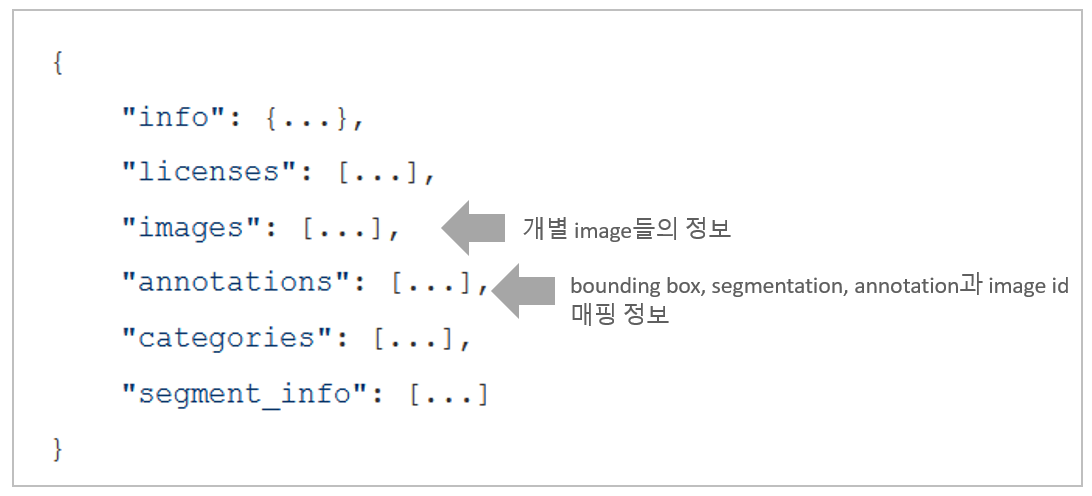

In [ ]:
!cat /kaggle/working/output_region.json

### via_region_data.json을 coco json annotation 형태로 변환
* 강의 영상은 colab 기준. /content 디렉토리를 kaggle 기준으로 현재 디렉토리 /kaggle/working 로 전환

In [ ]:
import json

with open('/kaggle/working/balloon/train/via_region_data.json') as json_file:
    data_infos = json.load(json_file)

print(data_infos)

In [ ]:
import os.path as osp
import json
from tqdm.notebook import tqdm
import cv2
# json을 coco json 형태로 변환
def convert_balloon_to_coco(ann_file, out_file, image_prefix):
  ''' ann_file은 via_region_data.json, out_file은 coco로 변환할 출력 json파일
      image_prefix는 image jpg가 있는 디렉토리 위치
  '''

  # json annotation 파일을 memory로 load
  #data_infos = mmcv.load(ann_file)
  with open(ann_file) as json_file:
    data_infos = json.load(json_file)

  # coco의 주요 key값인 annotations와 images를 담을 list 생성.
  annotations = []
  images = []
  obj_count = 0

  # 해당 json은 image의 filename+size로 고유 image id를 가짐.
  # 개별 고유 image id 별로 regions key값으로 object별 segmentation 정보를 polygon으로 가짐
  #for idx, v in enumerate(mmcv.track_iter_progress(data_infos.values())):.
  for idx, v in enumerate(tqdm(data_infos.values())):
    filename = v['filename']
    # images에 담을 개별 image의 정보를 dict로 생성.
    img_path = osp.join(image_prefix, filename)
    #height, width = mmcv.imread(img_path).shape[:2]
    height, width = cv2.imread(img_path).shape[:2]

    images.append(dict(
        id = idx,
        file_name = filename,
        height = height,
        width = width
    ))
    # annotations에 담을 bboxes와 poly 정보를 생성
    bboxes = []
    labels = []
    masks = []
    for _, obj in v['regions'].items():
      assert not obj['region_attributes']
      obj = obj['shape_attributes']
      # polygon x좌표 list와 , polygon y좌표 list를 이용하여 polygon x, y 연속 좌표 list로 변환.
      px = obj['all_points_x']
      py = obj['all_points_y']
      # polygon (x, y) 좌표로 변환.
      poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
      # polygon x,y 연속 좌표 list로 변환
      poly = [p for x in poly for p in x]

      # boundig box의 x, y, width, height를 segmentation 좌표 기반으로 구하기 위해, 최소/최대 x,y 좌표값을 구함.
      x_min, y_min, x_max, y_max = (min(px), min(py), max(px), max(py))
      # 개별 object의 segmentation 정보와 bbox, image id, 자신의 id 정보를 Dict로 형태.
      data_anno = dict(
          image_id = idx,
          id=obj_count,
          category_id = 0,
          bbox = [x_min, y_min, x_max - x_min, y_max - y_min],
          area = (x_max - x_min) * (y_max - y_min),
          segmentation = [poly],
          iscrowd = 0
      )
      # 개별 object의 정보를 annotations list에 추가.
      annotations.append(data_anno)
      obj_count += 1
  # images와 annotations, categories를 Dict형태로 저장.
  coco_format_json = dict(
      images = images,
      annotations = annotations,
      categories = [{'id':0, 'name':'balloon'}]
  )

  # json 파일로 출력.
  #mmcv.dump(coco_format_json, out_file)
  with open(out_file, 'w') as json_out_file:
    json.dump(coco_format_json, json_out_file)


In [ ]:
convert_balloon_to_coco('/kaggle/working/balloon/train/via_region_data.json', '/kaggle/working/balloon/train_coco.json', '/kaggle/working/balloon/train')
convert_balloon_to_coco('/kaggle/working/balloon/val/via_region_data.json', '/kaggle/working/balloon/val_coco.json', '/kaggle/working/balloon/val')

In [ ]:
!sudo apt-get install jq

In [ ]:
!jq . /kaggle/working/balloon/train_coco.json > output_train_coco.json

### pycocotools를 이용하여 변환된 coco json의 segmentation 시각화
* coco format으로 잘 변환되었는지 확인하기 위해 pycocotools로 특정 image id의 image filename및 segmentation 정보를 추출한 뒤 이를 시각화

In [ ]:
from pycocotools.coco import COCO

coco=COCO('/kaggle/working/balloon/train_coco.json')

In [ ]:
# category id와 image id 출력.
catIds = coco.getCatIds(catNms=['balloon']);
print(catIds)
# oco.getImgIds(catIds=catIds)는 해당 catogory id별로 한개의 image id을 임의로 출력
imgIds = coco.getImgIds(catIds=catIds )
print(imgIds)

In [ ]:
# image id 0번에 대한 image 정보와 해당 image의 object별 정보 추출.
img = coco.loadImgs(0)[0]
print(img)
annIds = coco.getAnnIds(imgIds=img['id'], catIds=[0], iscrowd=None)
anns = coco.loadAnns(annIds)
print(anns)

In [ ]:
import numpy as np

# coco data 실습에 사용된 시각화 함수를 그대로 가져옴.
def get_polygon_xy(ann_seg):
  polygon_x = [x for index, x in enumerate(ann_seg) if index % 2 == 0]
  polygon_y = [x for index, x in enumerate(ann_seg) if index % 2 == 1]
  polygon_xy = [[x, y] for x, y in zip(polygon_x, polygon_y)]
  polygon_xy = np.array(polygon_xy, np.int32)
  return polygon_xy

def get_mask(image_array_shape, polygon_xy):
  mask = np.zeros(image_array_shape)
  masked_polygon = cv2.fillPoly(mask, [polygon_xy], 1)

  return masked_polygon

def apply_mask(image, mask, color, alpha=0.5):
  for c in range(3):
    image[:, :, c] = np.where(mask == 1,
                              image[:, :, c] *
                              (1 - alpha) + alpha * color[c] * 255,
                              image[:, :, c])
  return image

# ann_seg_list에 있는 object들의 segmentation에 따라 instance segmentation 시각화.
def draw_segment(image_array, ann_seg_list, color_list, alpha):
  draw_image = image_array.copy()
  mask_array_shape = draw_image.shape[0:2]

  # list형태로 입력된 segmentation 정보들을 각각 시각화
  for index, ann_seg in enumerate(ann_seg_list):
    # polygon 좌표로 변환.
    polygon_xy = get_polygon_xy(ann_seg)
    # mask 정보 변환
    masked_polygon = get_mask(mask_array_shape, polygon_xy)

    # segmentation color와 외곽선용 color 선택
    color_object = color_list[np.random.randint(len(color_list))]
    color_contour = color_list[np.random.randint(len(color_list))]
    # masking 적용.
    masked_image = apply_mask(draw_image, masked_polygon, color_object, alpha=0.6)
    # 외곽선 적용.
    s_mask_int = (masked_polygon*255).astype("uint8")
    contours, hierarchy = cv2.findContours(s_mask_int, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    masked_image = cv2.drawContours(masked_image, contours, -1, color_contour, 1, cv2.LINE_8, hierarchy, 100)

  return masked_image

In [ ]:
color_list = [
              (0, 255, 0),
              (255, 0, 0),
              (0, 0, 255)
]
anns = coco.loadAnns(annIds)
# segmentation 정보만 별도로 추출.
ann_seg_list = [ann['segmentation'][0] for ann in anns]
print(ann_seg_list)

In [ ]:
import matplotlib.pyplot as plt
import cv2

# 원본 이미지 시각화
image_array = cv2.cvtColor(cv2.imread('/kaggle/working/balloon/train/34020010494_e5cb88e1c4_k.jpg'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 14))
plt.imshow(image_array)
plt.axis('off')

# coco segmentation 정보를 기반으로 segmentation 적용한 이미지 시각화
masked_image = draw_segment(image_array, ann_seg_list, color_list, alpha=0.6)
plt.figure(figsize=(12, 14))
plt.imshow(masked_image)
plt.axis('off')

### Pretrained 모델 다운로드, Config 설정
* 강의 영상은 colab 기준. /content 디렉토리를 kaggle 기준으로 현재 디렉토리 /kaggle/working 로 전환
* download.openmmlab.com 사이트의 ssl 이슈로 wget에 --no-check-certificate 추가

In [ ]:
# pretrained weight 모델을 다운로드 받기 위해서 mmdetection/checkpoints 디렉토리를 만듬.
!cd mmdetection; mkdir checkpoints

In [ ]:
!wget --no-check-certificate -O /kaggle/working/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth

In [ ]:
!ls -lia /kaggle/working/mmdetection/checkpoints

In [ ]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정.
config_file = '/kaggle/working/mmdetection/configs/mask_rcnn/mask_rcnn_r101_fpn_1x_coco.py'
checkpoint_file = '/kaggle/working/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth'

In [ ]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset

@DATASETS.register_module(force=True)
class BalloonDataset(CocoDataset):
  CLASSES = ('balloon', )

In [ ]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

In [ ]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정.
cfg.dataset_type = 'BalloonDataset'
cfg.data_root = '/kaggle/working/balloon/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정.
cfg.data.train.type = 'BalloonDataset'
cfg.data.train.data_root = '/kaggle/working/balloon/'
cfg.data.train.ann_file = 'train_coco.json'
cfg.data.train.img_prefix = 'train'

cfg.data.val.type = 'BalloonDataset'
cfg.data.val.data_root = '/kaggle/working/balloon/'
cfg.data.val.ann_file = 'val_coco.json'
cfg.data.val.img_prefix = 'val'


# class의 갯수 수정.
cfg.model.roi_head.bbox_head.num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# pretrained 모델
cfg.load_from = '/kaggle/working/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정.
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# CocoDataset의 경우 metric을 bbox로 설정해야 함.(mAP아님. bbox로 설정하면 mAP를 iou threshold를 0.5 ~ 0.95까지 변경하면서 측정)
cfg.evaluation.metric = ['bbox', 'segm']
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

# epochs 횟수는 36으로 증가
cfg.runner.max_epochs = 36

# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정.
cfg.lr_config.policy='step'
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# ConfigDict' object has no attribute 'device 오류 발생시 반드시 설정 필요. https://github.com/open-mmlab/mmdetection/issues/7901
cfg.device='cuda'

In [ ]:
print(cfg.pretty_text)

### 학습 수행

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성.
datasets = [build_dataset(cfg.data.train)]

In [ ]:
datasets[0]

In [ ]:
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES
print(model.CLASSES)

In [ ]:
import os.path as osp
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# epochs는 config의 runner 파라미터로 지정됨. 기본 12회
train_detector(model, datasets, cfg, distributed=False, validate=False)

### 단일 이미지와 Video Inference 수행.

In [ ]:
from mmdet.apis import inference_detector, show_result_pyplot

checkpoint_file = '/kaggle/working/tutorial_exps/epoch_36.pth'

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용.
model_ckpt = init_detector(cfg, checkpoint_file, device='cuda:0')

In [ ]:
# BGR Image 사용
#14898532020_ba6199dd22_k.jpg, 16335852991_f55de7958d_k.jpg
img = cv2.imread('/kaggle/working/balloon/val/16335852991_f55de7958d_k.jpg')
#model_ckpt.cfg = cfg

result = inference_detector(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, score_thr=0.5)

In [ ]:
import numpy as np

labels_to_names_seq =  {0:'balloon'}

colors = list(
    [[0, 255, 0],
     [0, 0, 255],
     [255, 0, 0],
     [0, 255, 255],
     [255, 255, 0],
     [255, 0, 255],
     [80, 70, 180],
     [250, 80, 190],
     [245, 145, 50],
     [70, 150, 250]] )

In [ ]:
# model과 원본 이미지 array, filtering할 기준 class confidence score를 인자로 가지는 inference 시각화용 함수 생성.
# 이미 inference 시 mask boolean값이 들어오므로 mask_threshold 값을 필요하지 않음.
def get_detected_img(model, img_array,  score_threshold=0.3, draw_box=True, is_print=True):
  # 인자로 들어온 image_array를 복사.
  draw_img = img_array.copy()
  bbox_color=(0, 255, 0)
  text_color=(0, 0, 255)

  # model과 image array를 입력 인자로 inference detection 수행하고 결과를 results로 받음.
  results = inference_detector(model, img_array)
  bbox_results = results[0]
  seg_results = results[1]

  # results 리스트를 loop를 돌면서 개별 2차원 array들을 추출하고 이를 기반으로 이미지 시각화
  # results 리스트의 위치 index가  Class id. 여기서는 result_ind가 class id
  # 개별 2차원 array에 오브젝트별 좌표와 class confidence score 값을 가짐.
  for result_ind, bbox_result in enumerate(bbox_results):
    # 개별 2차원 array의 row size가 0 이면 해당 Class id로 값이 없으므로 다음 loop로 진행.
    if len(bbox_result) == 0:
      continue

    mask_array_list = seg_results[result_ind]

    # 해당 클래스 별로 Detect된 여러개의 오브젝트 정보가 2차원 array에 담겨 있으며, 이 2차원 array를 row수만큼 iteration해서 개별 오브젝트의 좌표값 추출.
    for i in range(len(bbox_result)):
      # 좌상단, 우하단 좌표 추출.
      if bbox_result[i, 4] > score_threshold:
        left = int(bbox_result[i, 0])
        top = int(bbox_result[i, 1])
        right = int(bbox_result[i, 2])
        bottom = int(bbox_result[i, 3])
        caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], bbox_result[i, 4])
        if draw_box:
          cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
          cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)
        # masking 시각화 적용. class_mask_array는 image 크기 shape의  True/False값을 가지는 2차원 array
        class_mask_array = mask_array_list[i]
        # 원본 image array에서 mask가 True인 영역만 별도 추출.
        masked_roi = draw_img[class_mask_array]
        #color를 임의 지정
        #color_index = np.random.randint(0, len(colors)-1)
        # color를 class별로 지정
        color_index = result_ind % len(colors)
        color = colors[color_index]

        # apply_mask()함수를 적용시 수행 시간이 상대적으로 오래 걸림.
        #draw_img = apply_mask(draw_img, class_mask_array, color, alpha=0.4)
        # 원본 이미지의 masking 될 영역에 mask를 특정 투명 컬러로 적용
        draw_img[class_mask_array] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * masked_roi).astype(np.uint8)

        if is_print:
          print(caption)

  return draw_img

In [ ]:
import matplotlib.pyplot as plt

img_arr = cv2.imread('/kaggle/working/balloon/val/16335852991_f55de7958d_k.jpg')
detected_img = get_detected_img(model_ckpt, img_arr,  score_threshold=0.3, draw_box=False, is_print=True)
# detect 입력된 이미지는 bgr임. 이를 최종 출력시 rgb로 변환
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(14, 14))
plt.imshow(detected_img)

In [ ]:
# 원본 이미지를 Gray scale로 변환하고, 컬러 기반 instance segmentation을 적용하는 함수
def get_detected_img_n_gray(model, img_array,  score_threshold=0.3, draw_box=True, is_print=True):
  # 인자로 들어온 image_array를 복사.
  draw_img = img_array.copy()
  bbox_color=(0, 255, 0)
  text_color=(0, 0, 255)

  # model과 image array를 입력 인자로 inference detection 수행하고 결과를 results로 받음.
  # results는 80개의 2차원 array(shape=(오브젝트갯수, 5))를 가지는 list.
  results = inference_detector(model, img_array)
  bbox_results = results[0]
  seg_results = results[1]

  # 원본 이미지를 Grayscale로 변환. BGR2GRAY적용시 2차원 array로 변환되므로 다시 GRAY2BGR로 변환하면 3차원이지만, 여전히 Grayscale임.
  draw_img_gray = cv2.cvtColor(cv2.cvtColor(draw_img, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)

  # 80개의 array원소를 가지는 results 리스트를 loop를 돌면서 개별 2차원 array들을 추출하고 이를 기반으로 이미지 시각화
  # results 리스트의 위치 index가 바로 COCO 매핑된 Class id. 여기서는 result_ind가 class id
  # 개별 2차원 array에 오브젝트별 좌표와 class confidence score 값을 가짐.
  for result_ind, bbox_result in enumerate(bbox_results):
    # 개별 2차원 array의 row size가 0 이면 해당 Class id로 값이 없으므로 다음 loop로 진행.
    if len(bbox_result) == 0:
      continue

    mask_array_list = seg_results[result_ind]

    # 해당 클래스 별로 Detect된 여러개의 오브젝트 정보가 2차원 array에 담겨 있으며, 이 2차원 array를 row수만큼 iteration해서 개별 오브젝트의 좌표값 추출.
    for i in range(len(bbox_result)):
      # 좌상단, 우하단 좌표 추출.
      if bbox_result[i, 4] > score_threshold:
        left = int(bbox_result[i, 0])
        top = int(bbox_result[i, 1])
        right = int(bbox_result[i, 2])
        bottom = int(bbox_result[i, 3])
        caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], bbox_result[i, 4])
        if draw_box:
          cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
          cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)


        # masking 시각화 적용. class_mask_array는 image 크기 shape의  True/False값을 가지는 2차원 array
        class_mask_array = mask_array_list[i]
        # 원본 image array에서 mask가 True인 영역만 별도 추출. 색깔을 가지는 풍선 영역
        masked_roi = draw_img[class_mask_array]
        #color를 임의 지정
        #color_index = np.random.randint(0, len(colors)-1)
        # color를 class별로 지정
        color_index = result_ind % len(colors)
        color = colors[color_index]

        # 원본 이미지가 아닌 Gray scale 이미지 위에 masking 될 영역에 mask를 투명 컬러로 적용
        draw_img_gray[class_mask_array] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * masked_roi).astype(np.uint8)

        if is_print:
          print(caption)

  return draw_img_gray

In [ ]:

img_arr = cv2.imread('/kaggle/working/balloon/val/16335852991_f55de7958d_k.jpg')
detected_img = get_detected_img_n_gray(model_ckpt, img_arr,  score_threshold=0.3, draw_box=False, is_print=True)
# detect 입력된 이미지는 bgr임. 이를 최종 출력시 rgb로 변환
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(14, 14))
plt.imshow(detected_img)

In [ ]:
!mkdir ./data
!wget -O /kaggle/working/data/balloon_dog02.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/balloon_dog02.mp4?raw=true

In [ ]:
import time

def do_detected_video(model, input_path, output_path, score_threshold, do_print=True):

    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)
    btime = time.time()
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        stime = time.time()
        # Detect된 segmentation 영역만 컬러 처리하고, 나머지 영역은 Grayscale 처리.
        img_frame = get_detected_img_n_gray(model, img_frame, score_threshold=score_threshold, draw_box=False, is_print=False)
        if do_print:
          print('frame별 detection 수행 시간:', round(time.time() - stime, 4))
        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

    print('최종 detection 완료 수행 시간:', round(time.time() - btime, 4))

In [ ]:
do_detected_video(model_ckpt, '/kaggle/working/data/balloon_dog02.mp4', '/kaggle/working/data/balloon_dog02_out.avi', score_threshold=0.4, do_print=True)